In [1]:
### imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys 

sys.path.append('../')
sys.path.append('../src/')

from src.datahandling.loading import load_data
from src.datahandling.preprocessing import *
import src.datahandling.visualization as vis

# Data Inspection

This notebook serves the purpose of examining the data from the two datasets, Kelmarsh and Beberibe, utilized in this project, both originating from wind farms in the United Kingdom and Brazil, respectively. Additionally, we present our implemented data preprocessing transformers at the end of this notebook. 

**Short Description of the datasets:** 

1. [British](https://zenodo.org/record/5841834#.ZEajKXbP2BQ): The Kelmarsh dataset comprises information from six wind turbines at the coast of Britain spanning the years 2016 to 2022, with data being captured at 10-minute intervals. The dataset contains a total of 298 measured variables.

2. [Brazilian](https://zenodo.org/record/1475197#.ZD6iMxXP2WC): The Beberibe dataset includes information of six wind turbines at the coast of Brazil spanning the years 2013 and 2014. Data is captured in 10-minute intervals aswell. Overall there are 40 variables measured.

## Loading Data

In [2]:
### loading data
TURBINE_ID_BRITISH = 2
TURBINE_ID_BRAZILIAN = 1  ### for these two turbines benchmarks were provided
data_brit = load_data(turbine_id=TURBINE_ID_BRITISH, which_data="British")
data_braz = load_data(turbine_id=TURBINE_ID_BRAZILIAN, which_data="Brazilian")
data_brit.shape, data_braz.shape

((288864, 298), (52560, 40))

In [3]:
### eliminate columns with over 50% NaNs, since they are not useful
data_brit.dropna(axis=1, thresh=int(0.5*len(data_brit)), inplace=True)
data_braz.dropna(axis=1, thresh=int(0.5*len(data_braz)), inplace=True)
data_brit.shape, data_braz.shape

((288864, 169), (52560, 40))

We see that many features from the British dataset contain a lot of missing values. By eliminating those, we reduce the complexity of the next section which is feature selection. The Brazilian dataset on the other hand is complete, but contains much fewer features to begin with.

## Feature Selection

In this section we want to reduce ourselves to a reasonable number of features that provide all the necessary information to create a good model for predicting the power output of a wind turbine. Since we also want to do the transfer learning challenge we need to make sure that at least some of the features we select are also available in the both of the datasets.

### British Dataset

In [4]:
### printing all available features 
for key in data_brit.keys():
    print(key)

Wind speed (m/s)
Wind speed, Standard deviation (m/s)
Wind speed, Minimum (m/s)
Wind speed, Maximum (m/s)
Long Term Wind (m/s)
Wind speed Sensor 1 (m/s)
Wind speed Sensor 1, Standard deviation (m/s)
Wind speed Sensor 1, Minimum (m/s)
Wind speed Sensor 1, Maximum (m/s)
Wind speed Sensor 2 (m/s)
Wind speed Sensor 2, Standard deviation (m/s)
Wind speed Sensor 2, Minimum (m/s)
Wind speed Sensor 2, Maximum (m/s)
Density adjusted wind speed (m/s)
Wind direction (°)
Nacelle position (°)
Wind direction, Standard deviation (°)
Wind direction, Minimum (°)
Wind direction, Maximum (°)
Nacelle position, Standard deviation (°)
Nacelle position, Minimum (°)
Nacelle position, Maximum (°)
Vane position 1+2 (°)
Energy Export (kWh)
Energy Export counter (kWh)
Energy Import (kWh)
Lost Production (Contractual) (kWh)
Lost Production (Time-based IEC B.2.2) (kWh)
Lost Production (Time-based IEC B.2.3) (kWh)
Lost Production (Time-based IEC B.2.4) (kWh)
Lost Production (Time-based IEC B.3.2) (kWh)
Lost Producti

We select the variables that seem to be most relevant for our task. This is a somewhat arbitrary step and can be definitely improved with expert knowledge. 

In [5]:
### feature selection
preselected = [
    "Power (kW)",
    "Wind speed (m/s)",
    "Long Term Wind (m/s)",
    "Wind direction (°)",
    "Nacelle position (°)",
    "Nacelle ambient temperature (°C)",
    "Rotor speed (RPM)",
    "Yaw bearing angle (°)",
    "Density adjusted wind speed (m/s)",
]

We proceed with data cleansing, which involves eliminating any NaN values at the start or end of the dataframe and applying interpolation to fill in the NaNs within the middle portion. This process results in the generation of a time series for each feature, all of which do not have any missing values. For this purpose, the DataCleaner transformer is implemented. For further details, please refer to `src/datahandling/preprocessing.py`.

In [6]:
### cleaning data

cleaner = DataCleaner(
    features=preselected,
)

data_brit = cleaner.transform(data_brit)

Now, we look at correlations between the features:

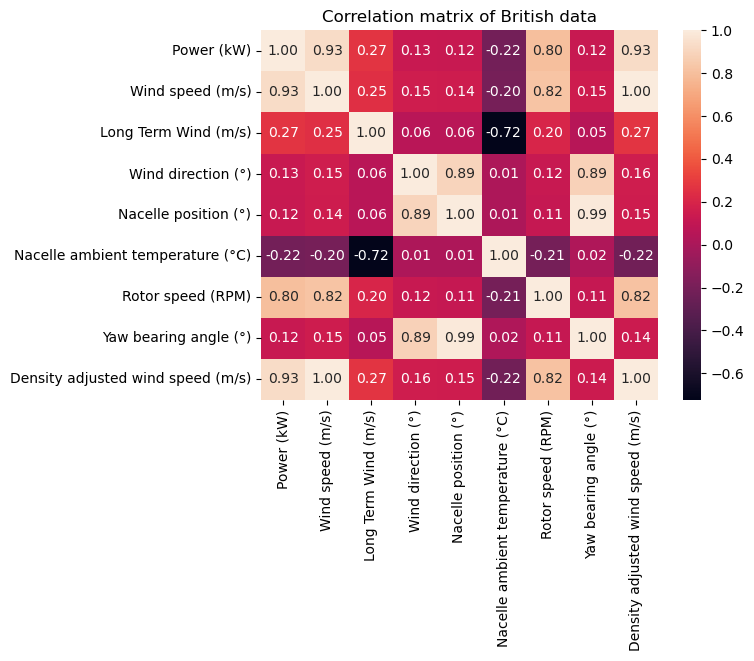

In [7]:
fig = sns.heatmap(data_brit.corr(), annot=True, fmt=".2f")
fig.set_title("Correlation matrix of British data")
plt.show()

/Users/haraldkugler/miniconda3/envs/res_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


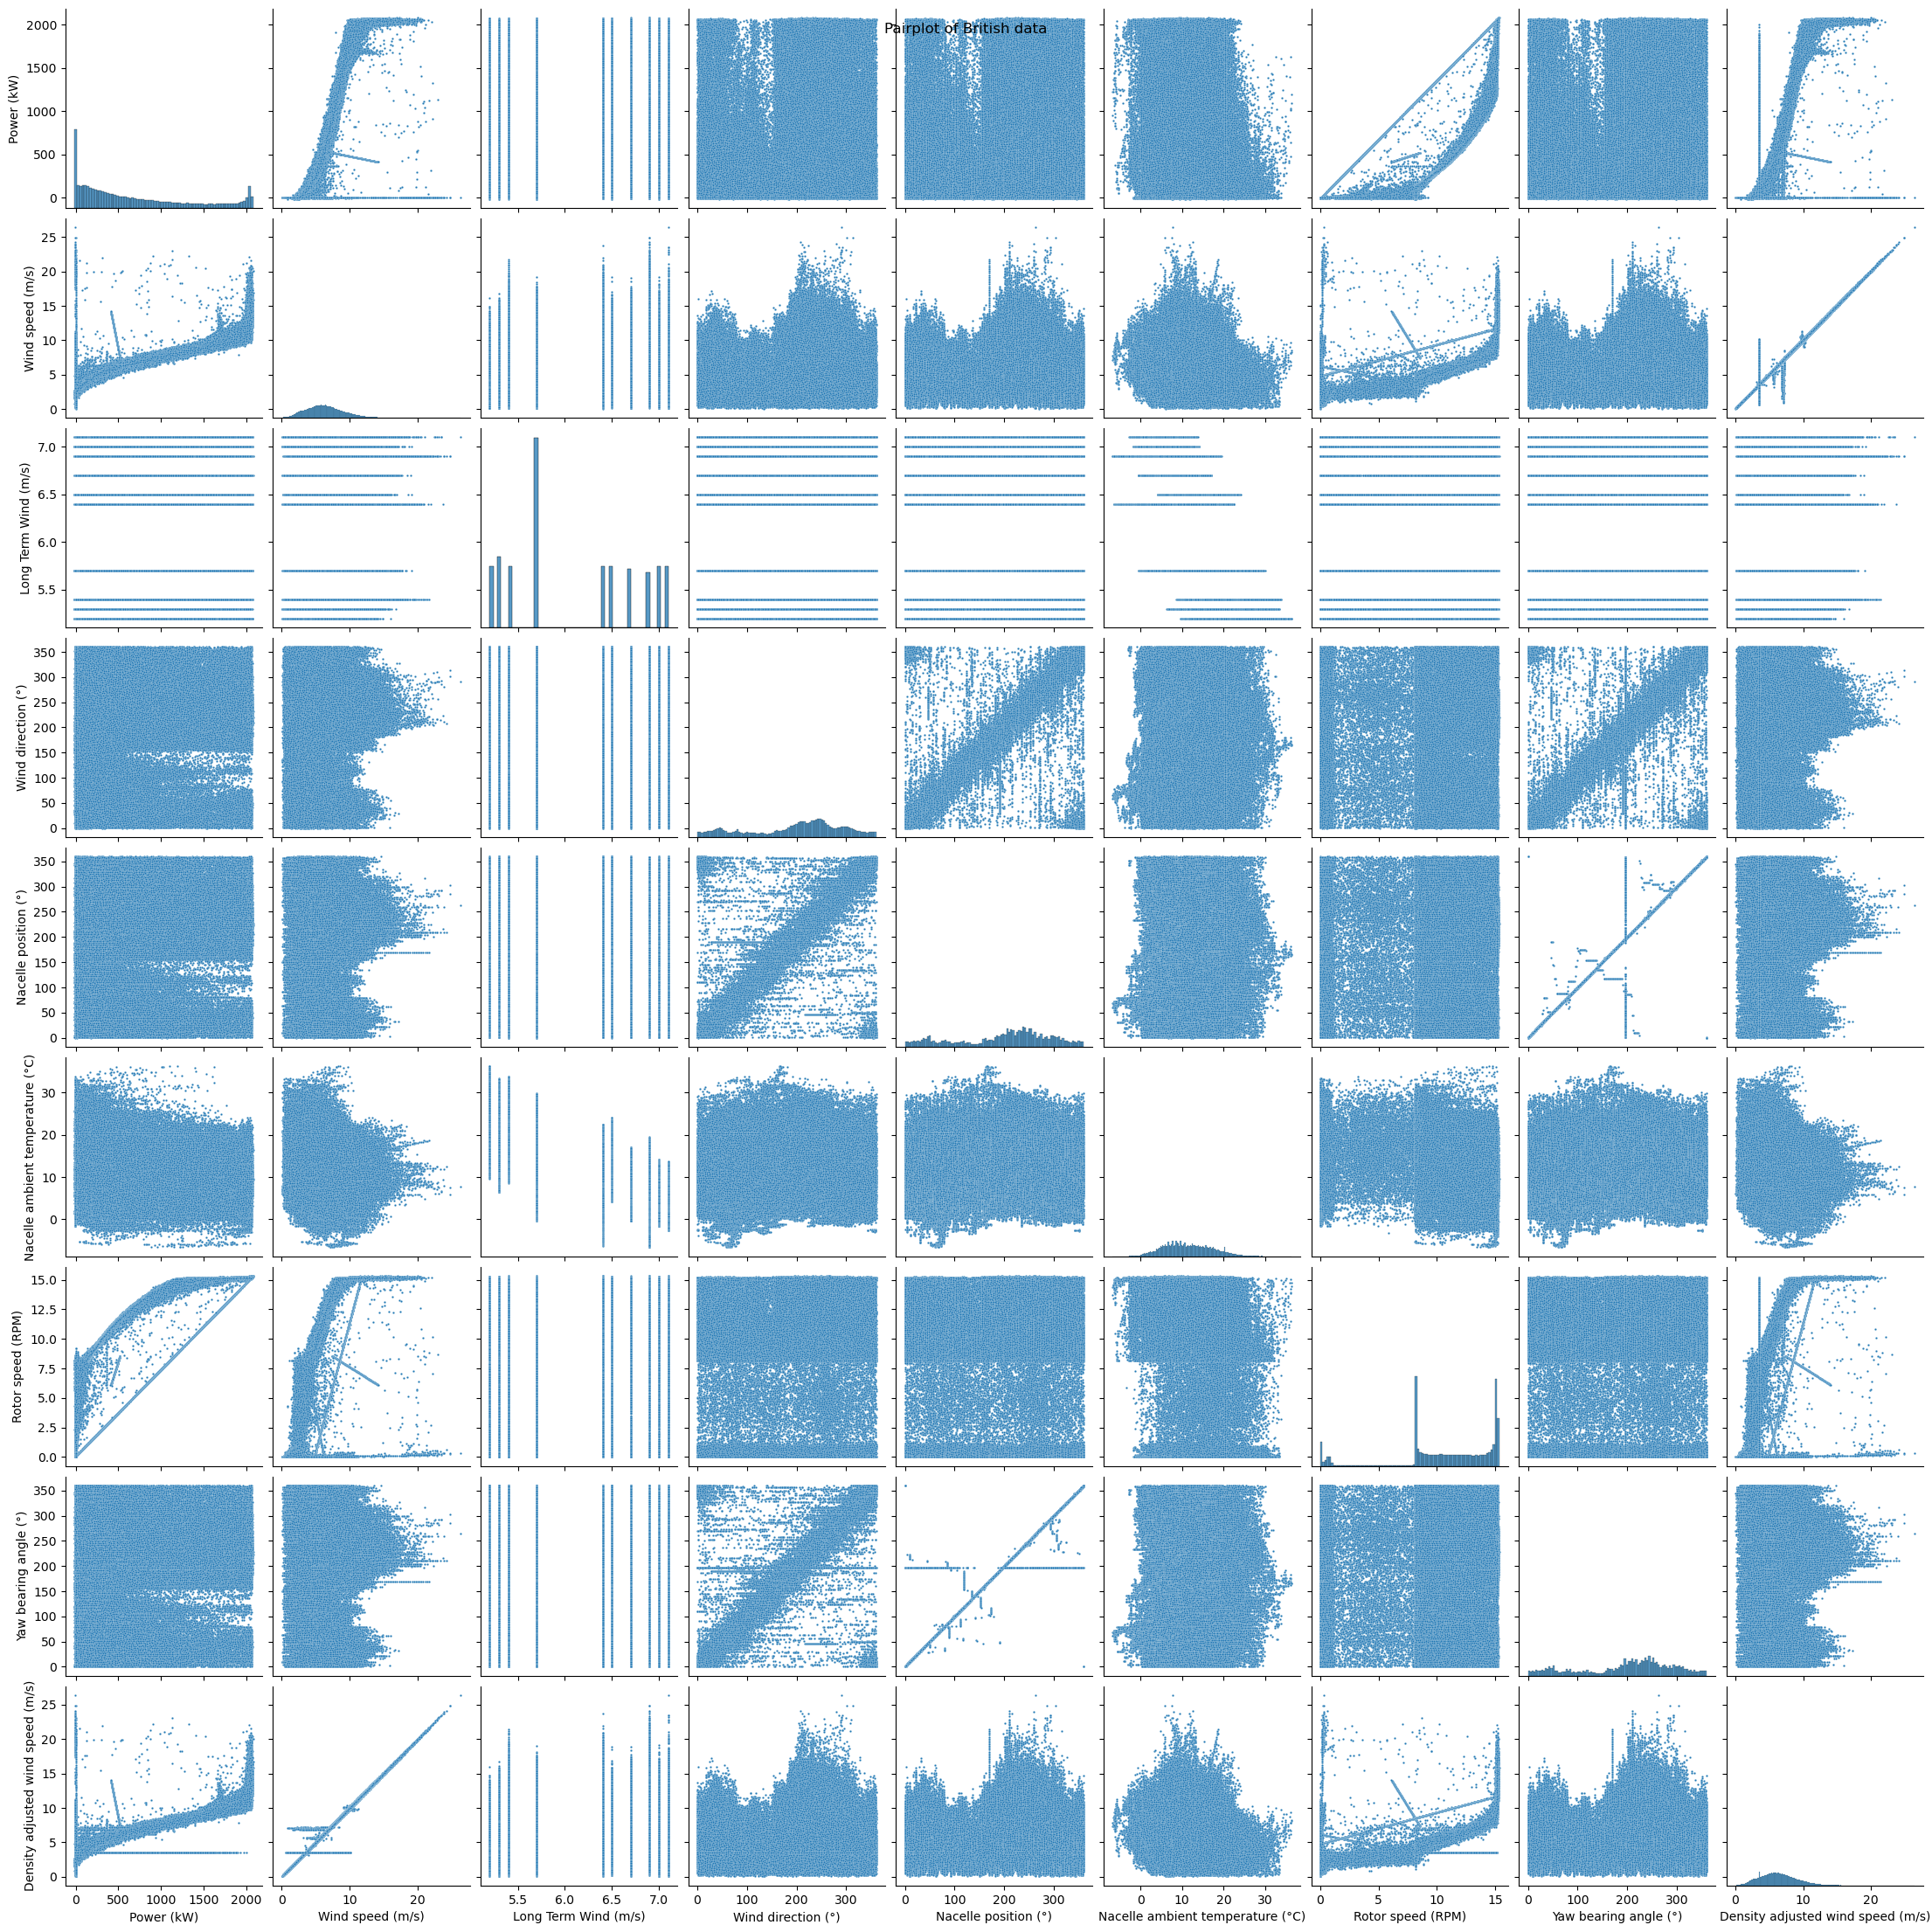

In [8]:
pair = sns.pairplot(data_brit, plot_kws={"s": 3})
pair.fig.suptitle("Pairplot of British data")
plt.show()

__Analysis:__

We observe that certain variables exhibit a perfect correlation with each other. We exclude these from our subsequent analysis since employing two predictors with a correlation of one would be redundant. Specifically, this pertains to the density-adjusted wind speed and the yaw bearing angle. Additionally, we disregard the long-term wind variable due to its discrete values and exclusive presence in the British dataset. Consequently, our models are permitted to utilize the following six features for forecasting:
- Power, which is also the target variable but past values are available
- Wind speed
- Wind direction
- Nacelle position
- Nacelle ambient temperature
- Rotor speed

We conclude this section by showing the time series of the target variable. To ensure visibility, we only plot the first 3000 values.

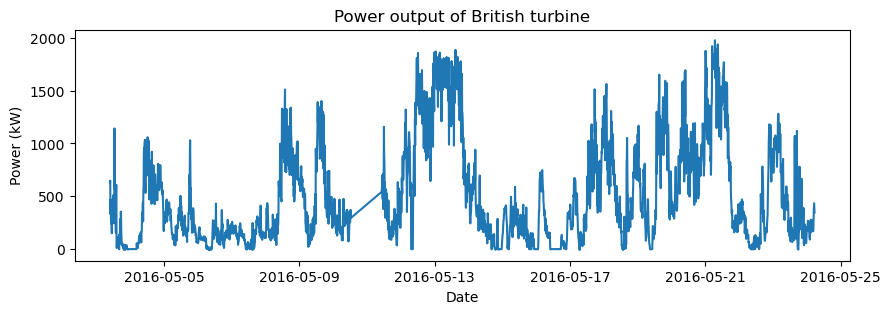

In [9]:
fig = plt.figure(figsize=(10, 3))
ax = sns.lineplot(data=data_brit["Power (kW)"][:3000])
ax.set_title("Power output of British turbine")
plt.show()

We cannot extract a remarkable pattern in the British data.

### Brazilian Dataset

In [10]:
### printing all available features
for key in data_braz.keys():
    print(key)

wind_speed
wind_direction
wind_speed_std
wind_direction_std
wind_speed_max
wind_speed_min
wind_speed_cube
air_temperature
relative_humidity
air_pressure
logger_temperature
battery_V
ws_u
ws_v
ws_w
sonic_temperature
sonic_wind_speed
sonic_wind_direction
tilt_X
tilt_Y
tilt_X_std
tilt_Y_std
wind_speed_nacelle
wind_speed_nacelle_max
wind_speed_nacelle_min
rotor_rpm
rotor_rpm_max
rotor_rpm_min
active_power_total
active_power_total_max
active_power_total_min
act_position
air_density
UST
UST_flag
HS
HS_flag
TKE
LMO
ws_w_corrected


Again, we have to remark that the preselection of features could be improved with further expert knowledge.

In [11]:
### feature selection

preselected = [
    "wind_speed",
    "wind_direction",
    "relative_humidity",
    "rotor_rpm",
    "active_power_total",
    "air_density",
]

In [12]:
### cleaning data

cleaner = DataCleaner(features=preselected)
data_braz = cleaner.transform(data_braz)

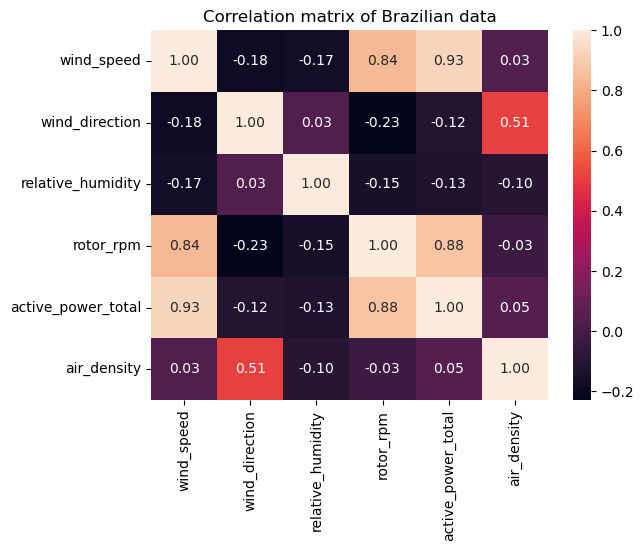

In [13]:
fig = sns.heatmap(data_braz.corr(), annot=True, fmt=".2f")
fig.set_title("Correlation matrix of Brazilian data")
plt.show()

/Users/haraldkugler/miniconda3/envs/res_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


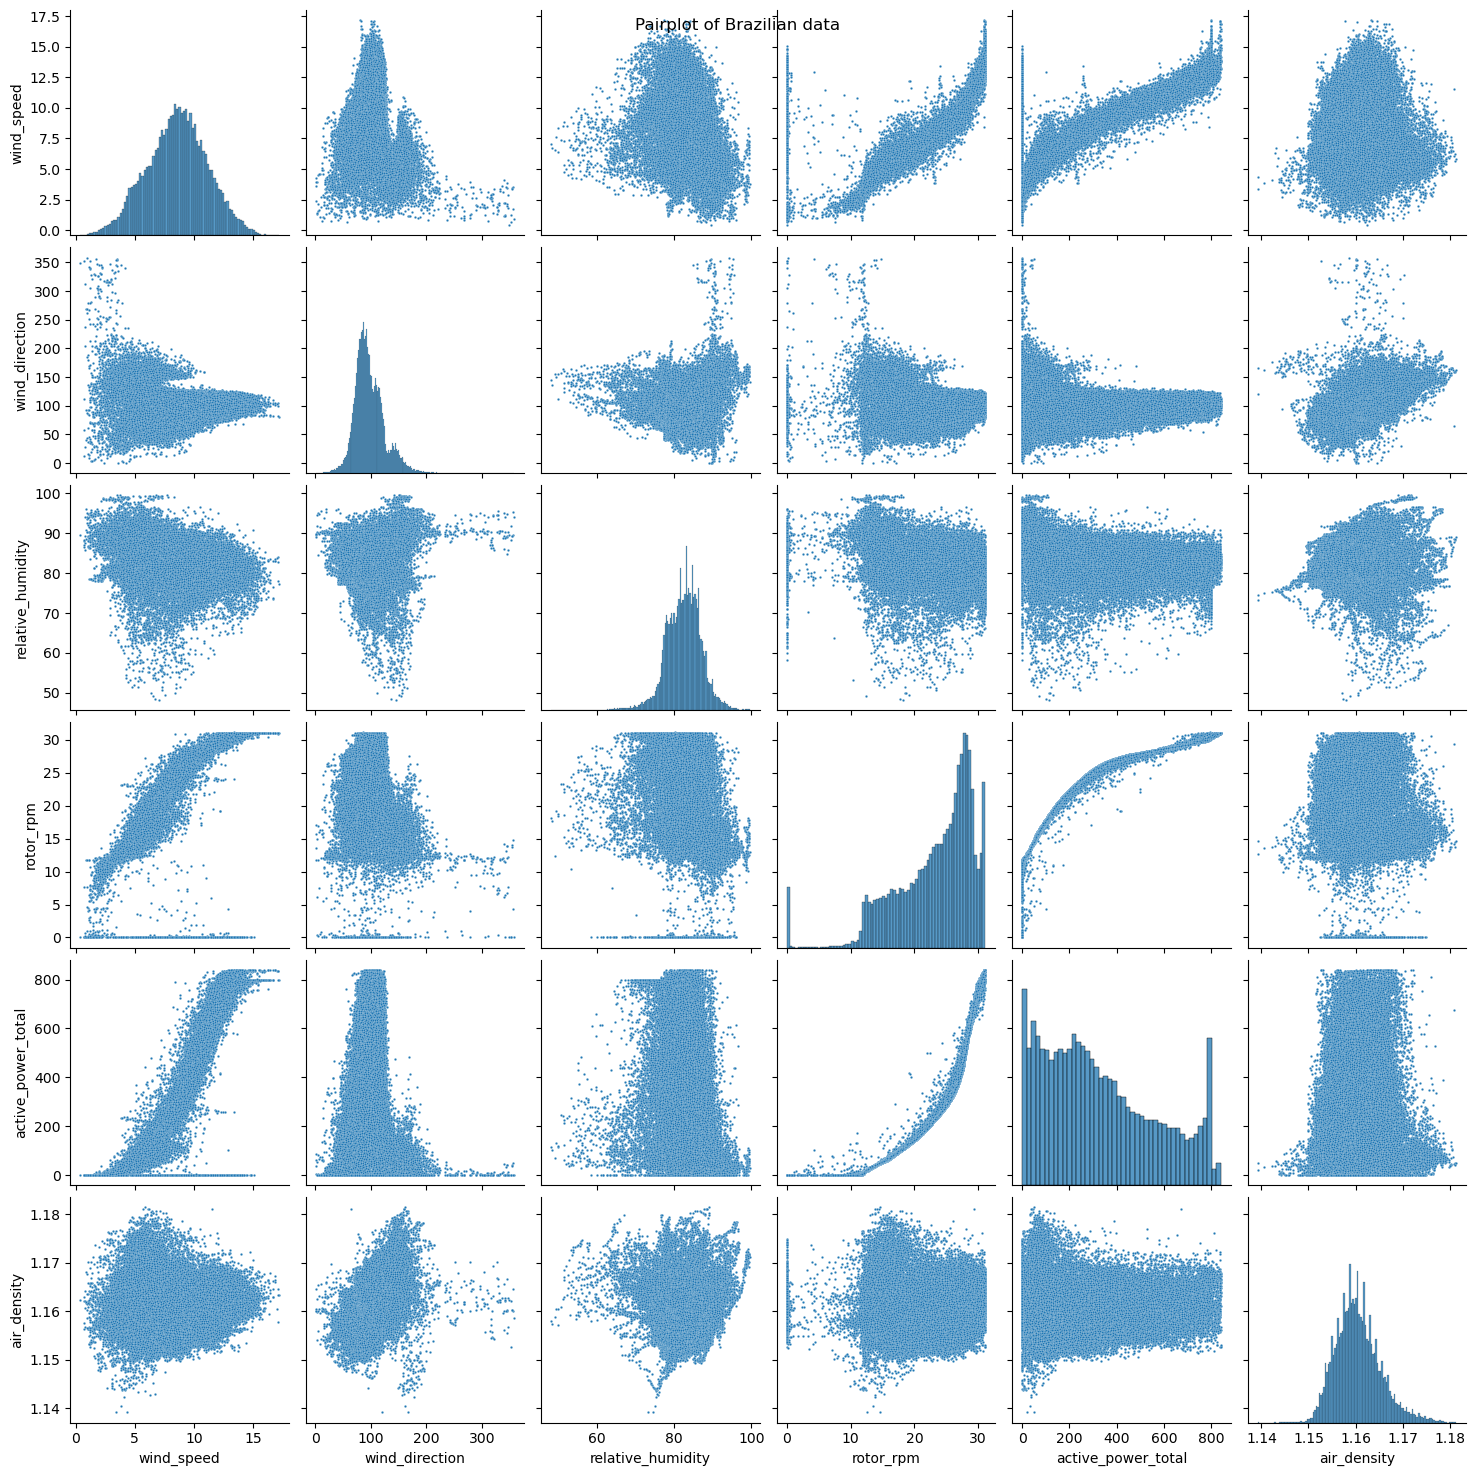

In [14]:
pair = sns.pairplot(data_braz, plot_kws={"s": 3})
pair.fig.suptitle("Pairplot of Brazilian data")
plt.show()

__Analysis:__

We do not observe any perfect correlations between the features. Furthermore, we cannot exclude any features due to the relationship between them. Consequently, we proceed our exploration with all 6 features.



Again, we conclude the section by showing the time series of the target variable. To ensure visibility, we only plot the first 3000 values.

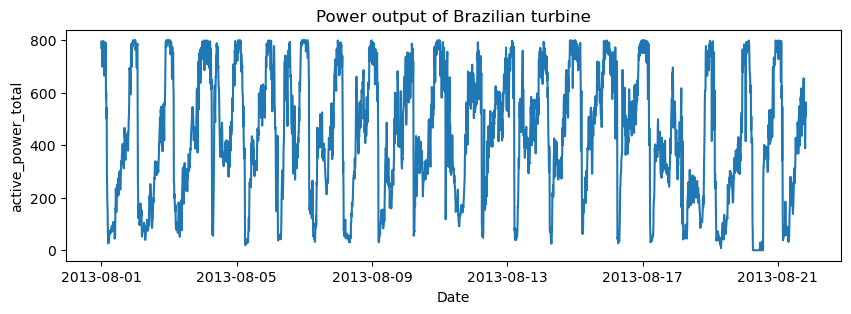

In [15]:
fig = plt.figure(figsize=(10, 3))
ax = sns.lineplot(data=data_braz["active_power_total"][:3000])
ax.set_title("Power output of Brazilian turbine")
plt.show()

We observe that there is a very regular periodicity present in the Brazilian data.

### Remarks to the Transfer Learning Challenge

The goal of the transfer learning challenge is to train a model on the British dataset and leverage it on the Brazilian dataset. Therefore, we need to make sure that the features we select are also available in the Brazilian dataset. We find that the following set of features is available in both datasets:

- Power
- Wind Speed
- Wind Direction
- Rotor Speed

## Data Transformations

To cross-validate our models, we decide to leverage the pipeline framework provided by sklearn. This enhances the convenience of tasks such as hyperparameter optimization and effectively utilizing the models. Consequently, all data transformations tailored to this project have been developed in a manner consistent with the transformers found in sklearn.preprocessing. Overall, these specific transformers where implemented:

- __DataCleaner__: The transformer is already exploited in this notebook. It is used to clean the data by eliminating NaN values and applying interpolation.
- __FeatureSelector__: This transformer is used to select a subset of features from the dataset. It is used in the transfer learning challenge to extract the common features of both datasets. In this way we avoid loading the datasets twice.
- __Normalizer__: Applies a standard scaler to the data, but in contrary to the implementation in sklearn it does not return a numpy array but a pandas dataframe. Thus, the column names are preserved.
- __SupervisedTransformer__: Given that we are working with time series data, it is necessary to preprocess the dataset to make it suitable for supervised learning algorithms like linear regression. This transformer accomplishes this by introducing new columns that contain shifted versions of the dataset. The number of shifts applied is determined by the "window_size" attribute. Furthermore, the transformer holds a "horizon" attribute, which specifies the number of time steps into the future the model should predict. This attribute determines the magnitude of the first shift applied to the dataset. Additionally, it holds the option to encode the time index as cyclical features. This is done by introducing two new columns, one for the sine and one for the cosine of the time index. 


Additionally, we leverage the Nystroem transformer from sklearn to approximate the kernel matrix. This is done to reduce the computational complexity of the kernel ridge regression model.

Note that performing a transform changes the dataset's shape by design for some transformers. In the following, a short demonstration of the SupervisedTransformer is given.

In [16]:
### demonstration of the supervised transformer
st = SupervisedTransformer(
    horizon="hourly", # specifies the task, i.e. the forecasting horizon
    window_size=3, # specifies how many time steps are used for prediction
    encode_time=["hour", "month"] # specifies which time features are cyclical encoded
)

st.fit(data_brit)
st.transform(data_brit).head()

Power (kW) (time -6)  Power (kW) (time -7)  \
Date                                                              
2016-05-03 11:00:00            331.481903            647.460205   
2016-05-03 11:10:00            468.506104            331.481903   
2016-05-03 11:20:00            289.882111            468.506104   
2016-05-03 11:30:00            239.563507            289.882111   
2016-05-03 11:40:00            394.898346            239.563507   

                     Power (kW) (time -8)  Wind speed (m/s) (time -6)  \
Date                                                                    
2016-05-03 11:00:00            630.782349                    5.057806   
2016-05-03 11:10:00            647.460205                    5.723492   
2016-05-03 11:20:00            331.481903                    4.905113   
2016-05-03 11:30:00            468.506104                    5.006634   
2016-05-03 11:40:00            289.882111                    5.657807   

                     Wind speed (m/s) (time -7)  Wind speed (m/s) (time -8)  \
Date                                                                          
2016-05-03 11:00:00                    6.852325                    7.122510   
2016-05-03 11:10:00                    5.057806                    6.852325   
2016-05-03 11:20:00                    5.723492                    5.057806   
2016-05-03 11:30:00                    4.905113                    5.723492   
2016-05-03 11:40:00                    5.006634                    4.905113   

                     Long Term Wind (m/s) (time -6)  \
Date                                                  
2016-05-03 11:00:00                             5.7   
2016-05-03 11:10:00                             5.7   
2016-05-03 11:20:00                             5.7   
2016-05-03 11:30:00                             5.7   
2016-05-03 11:40:00                             5.7   

                     Long Term Wind (m/s) (time -7)  \
Date                                                  
2016-05-03 11:00:00                             5.7   
2016-05-03 11:10:00                             5.7   
2016-05-03 11:20:00                             5.7   
2016-05-03 11:30:00                             5.7   
2016-05-03 11:40:00                             5.7   

                     Long Term Wind (m/s) (time -8)  \
Date                                                  
2016-05-03 11:00:00                             5.7   
2016-05-03 11:10:00                             5.7   
2016-05-03 11:20:00                             5.7   
2016-05-03 11:30:00                             5.7   
2016-05-03 11:40:00                             5.7   

                     Wind direction (°) (time -6)  ...  \
Date                                               ...   
2016-05-03 11:00:00                    270.577423  ...   
2016-05-03 11:10:00                    271.625793  ...   
2016-05-03 11:20:00                    288.565460  ...   
2016-05-03 11:30:00                    283.519012  ...   
2016-05-03 11:40:00                    271.447266  ...   

                     Yaw bearing angle (°) (time -6)  \
Date                                                   
2016-05-03 11:00:00                       251.585999   
2016-05-03 11:10:00                       275.627960   
2016-05-03 11:20:00                       276.829987   
2016-05-03 11:30:00                       276.829987   
2016-05-03 11:40:00                       274.899811   

                     Yaw bearing angle (°) (time -7)  \
Date                                                   
2016-05-03 11:00:00                       266.997314   
2016-05-03 11:10:00                       251.585999   
2016-05-03 11:20:00                       275.627960   
2016-05-03 11:30:00                       276.829987   
2016-05-03 11:40:00                       276.829987   

                     Yaw bearing angle (°) (time -8)  \
Date                                                   
2016-05-03 11:00:00   